In [1]:
import ollama

model = 'gemma3:4b-it-qat'
system_prompt = """
You are a helpful assistant specializing is English language.
Your job is to identify triplets of entity-relation-entity in given sentences.
for example: "Bilbo Baggins was celebrating his 111th birthday" -> Here head entity is Bilbo Baggins, relation is "celebrate" and tail entity is "birthday" with attribute "111th".
The extracted triples should be suitable and accurate for building Knowledge Graph.
You should keep in mind things needed for building high-quality knowledge graphs like :

1. coreference -> "Bilbo was celebrating his birthday. He gave ring to Frodo." => Here "He" also refers to Bilbo entity.
2. keep relations in root (lemma) form and avoid duplicate relations -> "Bilbo was celebrating his birthday. Frodo celebrated the party." => 
Here for both relations use "celebrate" as relation instead of "celebrating" and "celebrated" as two relations.
3. The returned text should be in exactly the same format as given above, no extra characters.
4. Pay attention to adjectives and process them as attributes in response wherever applicable.
5. Consider cleaned up form of text for entity extraction.
7. Follow any other best practices for knowledge graph construction.

You should return triplets in following format (no additional characters):
[{"head_entity":{"entity":<head_entity_value>,"attribute":<if any attributes else blank string>},"relation":{"relation":<relation_name>,"attribute":<if any attributes else blank string>},"tail_entity":{"entity":<tail_entity_value>,"attribute":<if any attributes else blank string>}}]
"""

with open("system_prompt.txt", "r") as file:
    system_prompt = file.read()

In [2]:
def remove_extras(text):
    return text.strip().replace("\n", "").replace("```", '').replace('json','')

In [6]:
response = ollama.chat(model=model, messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": "John's eating food. It is daytime. He sits on the chair."}
])
print(f'actual response: {response['message']['content']}')
remove_extras(response['message']['content'])

actual response: ```json
[
  {"head_entity":{"entity":"John","attribute":""},"relation":{"relation":"eat","attribute":""},"tail_entity":{"entity":"food","attribute":""}},
  {"head_entity":{"entity":"John","attribute":""},"relation":{"relation":"sit_on","attribute":""},"tail_entity":{"entity":"chair","attribute":""}}
]
```


'[  {"head_entity":{"entity":"John","attribute":""},"relation":{"relation":"eat","attribute":""},"tail_entity":{"entity":"food","attribute":""}},  {"head_entity":{"entity":"John","attribute":""},"relation":{"relation":"sit_on","attribute":""},"tail_entity":{"entity":"chair","attribute":""}}]'

In [7]:
with open("metamorphosis-kafka.txt", "r") as file:
    full_content = file.read()

print(f'total chars: {len(full_content)}')

total chars: 118475


In [8]:
first_para = full_content[:531]
first_para = ".".join(full_content.split(".")[:10])
# first_para = """My name is Asutosh Nayak. I'm a software Engineer with no ambition. I play video games in my free time. He has no ambition."""
first_para

'Metamorphosis\n\nby Franz Kafka\n\nTranslated by David Wyllie\n\nI\n\n\nOne morning, when Gregor Samsa woke from troubled dreams, he found\nhimself transformed in his bed into a horrible vermin. He lay on his\narmour-like back, and if he lifted his head a little he could see his\nbrown belly, slightly domed and divided by arches into stiff sections.\nThe bedding was hardly able to cover it and seemed ready to slide off\nany moment. His many legs, pitifully thin compared with the size of the\nrest of him, waved about helplessly as he looked.\n\n“What’s happened to me?” he thought. It wasn’t a dream. His room, a\nproper human room although a little too small, lay peacefully between\nits four familiar walls. A collection of textile samples lay spread out\non the table—Samsa was a travelling salesman—and above it there hung a\npicture that he had recently cut out of an illustrated magazine and\nhoused in a nice, gilded frame. It showed a lady fitted out with a fur\nhat and fur boa who sat

In [9]:
import json
import re

def process_chunk(text, out):
    response = ollama.chat(model=model, messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": text}
        ])
    # print(f'actual response: {response['message']['content']}')
    # resp_content = re.sub(r"[\n,'json','```']", '', response['message']['content'])
    # pattern = r"\[(.*?)\]"
    # matches = re.findall(pattern, text)
    # print(f'matches: {matches}')
    # resp_content = matches[0]
    resp_content = remove_extras(response['message']['content'])
    # print(f'response_text: {resp_content}')
    try:
        t = json.loads(resp_content)
        out.extend(t)
    except json.JSONDecodeError:
        print(f"Failed to decode JSON from response: {resp_content}")
    return response

In [10]:
import pickle

def save_obj(data, filename):
    with open(filename, "wb") as f:
        pickle.dump(data, f)

In [ ]:
from tqdm.notebook import trange

all_triplets = []

sentences = full_content.split('.')
batch_size = 10
for i in trange(0, len(sentences), batch_size):
    batch = sentences[i:i+batch_size]
    paragraph = ".".join(batch)
    process_chunk(paragraph, all_triplets)
    if i % 100:
        save_obj(all_triplets, "all_triplets.pkl")

len(all_triplets)
save_obj(all_triplets, "all_triplets.pkl")

  0%|          | 0/74 [00:00<?, ?it/s]

Failed to decode JSON from response: [  {"head_entity":{"entity":"she","attribute":""},  {"relation":{"relation":"notice","attribute":""},  {"tail_entity":{"entity":"him","attribute":""}},  {"head_entity":{"entity":"she","attribute":""},  {"relation":{"relation":"slam","attribute":"negated"},  {"tail_entity":{"entity":"door","attribute":""}},  {"head_entity":{"entity":"she","attribute":""},  {"relation":{"relation":"regret","attribute":""},  {"tail_entity":{"entity":"behaviour","attribute":""}},  {"head_entity":{"entity":"she","attribute":""},  {"relation":{"relation":"enter","attribute":""},  {"tail_entity":{"entity":"room","attribute":"seriously ill"}},  {"head_entity":{"entity":"Gregor","attribute":""},  {"relation":{"relation":"watch","attribute":""},  {"tail_entity":{"entity":"him","attribute":""}},  {"head_entity":{"entity":"Gregor","attribute":""},  {"relation":{"relation":"require","attribute":""},  {"tail_entity":{"entity":"food","attribute":"suitable"}},  {"head_entity":{"ent

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

G = nx.MultiDiGraph()

# Add nodes and edges
for triple in tqdm(all_triplets):
    head = triple['head_entity']['entity']
    if 'tail_entity' in triple:
        tail = triple['tail_entity']['entity']
    else:
        tail = "null"
        print(f'triple with no tail entity: {triple}')
    relation = triple['relation']['relation']
    
    # Add nodes with attributes if available
    G.add_node(head, attr=triple['head_entity']['attribute'])
    G.add_node(tail, attr=triple['tail_entity']['attribute'] if 'tail_entity' in triple and 'attribute' in triple['tail_entity'] else "")
    
    # Add edge with relation label
    G.add_edge(head, tail, relation=relation)

  0%|          | 0/712 [00:00<?, ?it/s]

triple with no tail entity: {'head_entity': {'entity': 'Gregor Samsa', 'attribute': ''}, 'relation': {'relation': 'get_out', 'attribute': 'negated'}}
triple with no tail entity: {'head_entity': {'entity': 'Gregor Samsa', 'attribute': ''}, 'relation': {'relation': 'have', 'attribute': 'expected'}}
triple with no tail entity: {'head_entity': {'entity': 'Gregor Samsa', 'attribute': ''}, 'relation': {'relation': 'concern', 'attribute': 'loud_noise'}}
triple with no tail entity: {'head_entity': {'entity': 'Gregor Samsa', 'attribute': ''}, 'relation': {'relation': 'have', 'attribute': 'concern'}}
triple with no tail entity: {'head_entity': {'entity': 'Gregor Samsa', 'attribute': ''}, 'relation': {'relation': 'have', 'attribute': 'concern'}}
triple with no tail entity: {'head_entity': {'entity': 'Gregor Samsa', 'attribute': ''}, 'relation': {'relation': 'have', 'attribute': 'concern'}}
triple with no tail entity: {'head_entity': {'entity': 'Gregor Samsa', 'attribute': ''}, 'relation': {'relat

In [24]:
from pyvis.network import Network
import networkx as nx

# G = nx.karate_club_graph()  # example graph

net = Network(notebook=True, cdn_resources='in_line')
net.from_nx(G)
net.show("graph_metam_kafka.html")

graph_metam_kafka.html


{('Gregor Samsa',
  'vermin'): Text(0.36720587945989003, 0.1708620676289938, 'transform'),
 ('Gregor Samsa',
  'himself'): Text(-0.518945024191747, 0.15356438447656795, 'rest'),
 ('Gregor Samsa',
  'to get up'): Text(0.24997860435349795, 0.32905648156477185, 'want'),
 ('Gregor Samsa',
  'to dress'): Text(0.22000331088714553, -0.4662286402596709, 'want'),
 ('Gregor Samsa',
  'to eat breakfast'): Text(-0.1826034479338028, -0.5025290560558993, 'want'),
 ('Gregor Samsa',
  'what to do'): Text(0.4311926062231115, 0.047140159663992875, 'consider'),
 ('Gregor Samsa',
  'a slight pain'): Text(-0.20000568910007388, -0.5086465729639504, 'feel'),
 ('Gregor Samsa',
  'imagination'): Text(-0.3903355435604561, -0.3416194561294206, 'feel'),
 ('Gregor Samsa',
  'how his imaginings'): Text(0.3290662178045827, 0.2370498310487883, 'wonder'),
 ('Gregor Samsa',
  'change in his voice'): Text(0.4389126402231396, -0.07822115705282462, 'doubt'),
 ('Gregor Samsa',
  'a serious cold'): Text(-0.45741332828401093

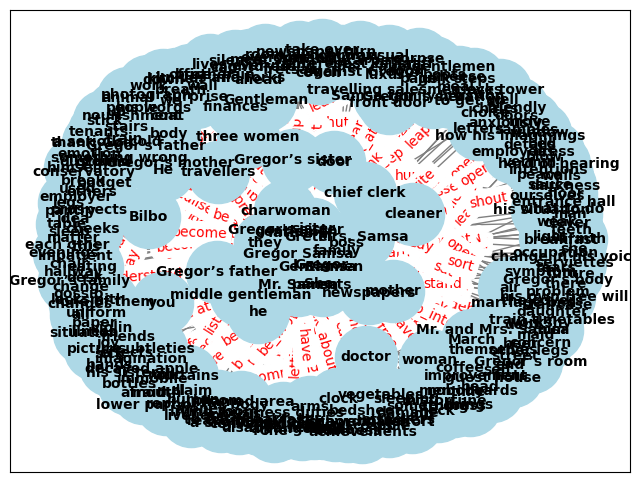

In [19]:
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # layout for visualization

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue")
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Draw edge labels (relations)
edge_labels = {(u, v): d['relation'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")